In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import random



# Data Directory (Update path accordingly)
IRMAS_PATH = '/content/IRMAS-TrainingData'

# Install required libraries
!pip install librosa

def pad_or_truncate(spec, target_shape=(128, 128)):
    """Ensure all spectrograms are of uniform size by padding or truncating."""
    pad_width = [(0, max(0, target_shape[0] - spec.shape[0])),
                 (0, max(0, target_shape[1] - spec.shape[1]))]
    spec = np.pad(spec, pad_width, mode='constant')
    return spec[:target_shape[0], :target_shape[1]]

def load_audio_files(directory, sr=22050, target_shape=(128, 128)):
    """Load audio files, convert to Mel spectrograms, and fix shape inconsistencies."""
    mel_specs = []
    labels = []
    class_map = {}
    class_id = 0

    for instrument in os.listdir(directory):
        instrument_path = os.path.join(directory, instrument)
        if os.path.isdir(instrument_path):
            class_map[instrument] = class_id
            for file in os.listdir(instrument_path):
                file_path = os.path.join(instrument_path, file)
                if file.endswith('.wav'):
                    y, _ = librosa.load(file_path, sr=sr)
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    mel_spec_db = pad_or_truncate(mel_spec_db, target_shape)

                    mel_specs.append(mel_spec_db)
                    labels.append(class_id)
            class_id += 1

    return np.array(mel_specs), np.array(labels), class_map

# Load data
mel_specs, labels, class_map = load_audio_files(IRMAS_PATH)

# Normalize data
mel_specs = mel_specs[..., np.newaxis]  # Add channel dimension
mel_specs = (mel_specs - np.min(mel_specs)) / (np.max(mel_specs) - np.min(mel_specs))  # Min-max scaling

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(mel_specs, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical
num_classes = len(class_map)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
model = create_cnn_model(X_train.shape[1:], num_classes)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=60,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stop])

# Save model
model.save("/content/drive/MyDrive/irmas_cnn_model.h5")

# Evaluate model
eval_result = model.evaluate(X_test, y_test)
print("Test Accuracy: {eval_result[1] * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.2206 - loss: 2.3493 - val_accuracy: 0.1014 - val_loss: 3.3166 - learning_rate: 5.0000e-04
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.3362 - loss: 1.9806 - val_accuracy: 0.1156 - val_loss: 3.8934 - learning_rate: 5.0000e-04
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4188 - loss: 1.7658 - val_accuracy: 0.1283 - val_loss: 3.4054 - learning_rate: 5.0000e-04
Epoch 4/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4753 - loss: 1.5827 - val_accuracy: 0.2744 - val_loss: 2.7047 - learning_rate: 5.0000e-04
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5327 - loss: 1.4303 - val_accuracy: 0.2170 - val_loss: 3.0486 - learning_rate: 5.0000e-04
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5759 - loss: 1.2980 - val_accuracy: 0.2125 - val_loss: 4.8879 - learning_rate: 5.0000e-04
Epoch 7/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7847 - loss: 0.7745
Test Accuracy: {eval_result[1] * 100:.2f}%


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import random

# Data Directory (Update path accordingly)
IRMAS_PATH = '/content/IRMAS-TestingData'

# Install required libraries
!pip install librosa

def pad_or_truncate(spec, target_shape=(128, 128)):
    """Ensure all spectrograms are of uniform size by padding or truncating."""
    pad_width = [(0, max(0, target_shape[0] - spec.shape[0])),
                 (0, max(0, target_shape[1] - spec.shape[1]))]
    spec = np.pad(spec, pad_width, mode='constant')
    return spec[:target_shape[0], :target_shape[1]]

def load_audio_files(directory, sr=22050, target_shape=(128, 128)):
    """Load audio files, convert to Mel spectrograms, and fix shape inconsistencies."""
    mel_specs = []
    labels = []
    class_map = {}
    class_id = 0

    for instrument in os.listdir(directory):
        instrument_path = os.path.join(directory, instrument)
        if os.path.isdir(instrument_path):
            class_map[instrument] = class_id
            for file in os.listdir(instrument_path):
                file_path = os.path.join(instrument_path, file)
                if file.endswith('.wav'):
                    y, _ = librosa.load(file_path, sr=sr)
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    mel_spec_db = pad_or_truncate(mel_spec_db, target_shape)

                    mel_specs.append(mel_spec_db)
                    labels.append(class_id)
            class_id += 1

    return np.array(mel_specs), np.array(labels), class_map

# Load data
mel_specs, labels, class_map = load_audio_files(IRMAS_PATH)

# Normalize data using Z-score normalization
mel_specs = mel_specs[..., np.newaxis]  # Add channel dimension
mean = np.mean(mel_specs)
std = np.std(mel_specs)
mel_specs = (mel_specs - mean) / std  # Standardization

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(mel_specs, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical
num_classes = len(class_map)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),  # Increased Dense units
        Dropout(0.4),  # Reduced dropout slightly
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=AdamW(learning_rate=0.0003),  # Changed optimizer to AdamW
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
model = create_cnn_model(X_train.shape[1:], num_classes)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=75,  # Increased epochs
                    batch_size=32,
                    callbacks=[reduce_lr, early_stop])

# Save model
model.save("/content/drive/MyDrive/irmas_cnn_model.h5")

# Evaluate model
eval_result = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {eval_result[1] * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.2051 - loss: 2.3577 - val_accuracy: 0.1133 - val_loss: 3.2833 - learning_rate: 3.0000e-04
Epoch 2/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3386 - loss: 2.0559 - val_accuracy: 0.0731 - val_loss: 4.8277 - learning_rate: 3.0000e-04
Epoch 3/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4002 - loss: 1.8404 - val_accuracy: 0.1365 - val_loss: 3.3049 - learning_rate: 3.0000e-04
Epoch 4/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4605 - loss: 1.6297 - val_accuracy: 0.3796 - val_loss: 1.9080 - learning_rate: 3.0000e-04
Epoch 5/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5044 - loss: 1.5446 - val_accuracy: 0.4124 - val_loss: 1.9381 - learning_rate: 3.0000e-04
Epoch 6/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5528 - loss: 1.4045 - val_accuracy: 0.5720 - val_loss: 1.3623 - learning_rate: 3.0000e-04
Epoch 7/75
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7343 - loss: 1.0282
Test Accuracy: 74.79%


In [ ]:
!unzip "/content/drive/MyDrive/IRMAS-TrainingData.zip"

Streaming output truncated to the last 5000 lines.
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0557__1.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0557__2.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0557__3.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0558__1.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0558__2.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0560__1.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0560__2.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0560__3.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0564__1.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0564__2.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0564__3.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0565__1.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0565__2.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]0565__3.wav  
  inflating: IRMAS-TrainingData/gac/[gac][pop_roc]056

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.2143 - loss: 2.3124 - val_accuracy: 0.1260 - val_loss: 2.8450 - learning_rate: 5.0000e-04
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.3253 - loss: 2.0012 - val_accuracy: 0.1201 - val_loss: 2.8543 - learning_rate: 5.0000e-04
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4145 - loss: 1.7890 - val_accuracy: 0.1693 - val_loss: 4.5452 - learning_rate: 5.0000e-04
Epoch 4/60
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4853 - loss: 1.5812
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4855 - loss: 1.5809 - val_accuracy: 0.1752 - val_loss: 3.3092 - learning_rate: 5.0000e-04
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5494 - loss: 1.3975 - val_accuracy: 0.3445 - val_loss: 2.0428 - learning_rate: 2.5000e-04
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accura

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7831 - loss: 0.7364
Test Accuracy: {eval_result[1] * 100:.2f}%
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


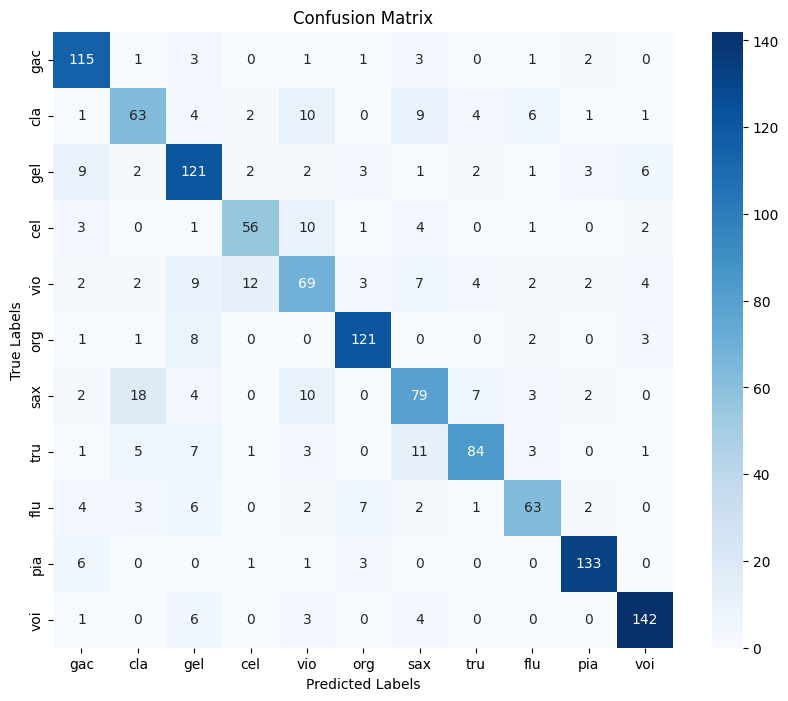

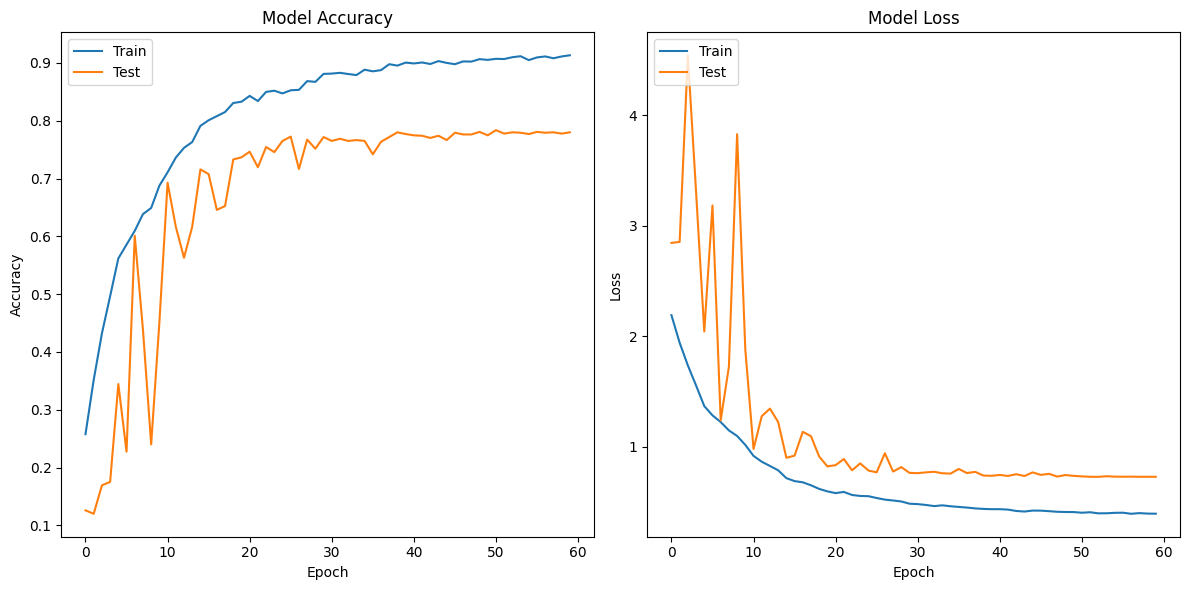

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import random



# Data Directory (Update path accordingly)
IRMAS_PATH = '/content/IRMAS-TrainingData'

# Install required libraries
!pip install librosa

def pad_or_truncate(spec, target_shape=(128, 128)):
    """Ensure all spectrograms are of uniform size by padding or truncating."""
    pad_width = [(0, max(0, target_shape[0] - spec.shape[0])),
                 (0, max(0, target_shape[1] - spec.shape[1]))]
    spec = np.pad(spec, pad_width, mode='constant')
    return spec[:target_shape[0], :target_shape[1]]

def load_audio_files(directory, sr=22050, target_shape=(128, 128)):
    """Load audio files, convert to Mel spectrograms, and fix shape inconsistencies."""
    mel_specs = []
    labels = []
    class_map = {}
    class_id = 0

    for instrument in os.listdir(directory):
        instrument_path = os.path.join(directory, instrument)
        if os.path.isdir(instrument_path):
            class_map[instrument] = class_id
            for file in os.listdir(instrument_path):
                file_path = os.path.join(instrument_path, file)
                if file.endswith('.wav'):
                    y, _ = librosa.load(file_path, sr=sr)
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    mel_spec_db = pad_or_truncate(mel_spec_db, target_shape)

                    mel_specs.append(mel_spec_db)
                    labels.append(class_id)
            class_id += 1

    return np.array(mel_specs), np.array(labels), class_map

# Load data
mel_specs, labels, class_map = load_audio_files(IRMAS_PATH)

# Normalize data
mel_specs = mel_specs[..., np.newaxis]  # Add channel dimension
mel_specs = (mel_specs - np.min(mel_specs)) / (np.max(mel_specs) - np.min(mel_specs))  # Min-max scaling

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(mel_specs, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical
num_classes = len(class_map)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
model = create_cnn_model(X_train.shape[1:], num_classes)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=60,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stop])

# Save model
model.save("/content/drive/MyDrive/irmas_cnn_model.h5")

# Evaluate model
eval_result = model.evaluate(X_test, y_test)
print("Test Accuracy: {eval_result[1] * 100:.2f}%")

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert true labels to class labels

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Plot
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()